# 本模块实现特征衍生

In [219]:
import pandas as pd
import numpy as np
# base
import math

import pandas as pd
import numpy as np
import sys
import datetime
import re
# data process
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures, LabelBinarizer
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype
from sklearn.feature_extraction import DictVectorizer
import seaborn as sns
# model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
import lightgbm as lgb
# model test
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## 合并处理训练样本和预测样本

In [220]:
# 训练样本 ：(1368146, 55)，总计15000个不同的用户，日期为2015-3-1至2016-2-23，不均匀分布,正负bi：14230:770
# data_path = "./data/train.tsv"
# data_id = "./data/train_id.tsv"
data_path = "./data/train.tsv"
data_id = "./data/train_id.tsv"
dat = pd.read_csv(data_path, sep='\t')
dat_id = pd.read_csv(data_id,sep="\t")

train_data  = pd.merge(dat,dat_id, how="inner", on="PERSONID")

print(train_data.shape)
train_data.head()

(1368146, 56)


,PERSONID,APPLYNO,FTR0,FTR1,FTR2,FTR3,FTR4,FTR5,FTR6,FTR7,...,FTR44,FTR45,FTR46,FTR47,FTR48,FTR49,FTR50,FTR51,CREATETIME,LABEL
0,8ba94305557a4ec72435a9eb78001350,20fab21284e57a4ccd3127553920e37b,0.050000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.050000,0.0,0.0,0.000000,0.050012,0.0,0.001532,A2B186C398E0D0,2015-09-14,0
1,8ba94305557a4ec72435a9eb78001350,73f32b8b6e199129abb8fe0cb6d6c867,0.033333,0.0,0.0,0.0,0.0,0.007829,0.0,0.0,...,0.033333,0.0,0.0,0.000000,0.033333,0.0,0.005156,A24B176C1239E0D0,2015-09-14,0
2,8ba94305557a4ec72435a9eb78001350,324da7a0b1a5c1d3b321685d734a9dc8,0.050000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.050000,0.0,0.0,0.000023,0.050000,0.0,0.000000,A0B0C6E0D0,2015-09-14,0
3,8ba94305557a4ec72435a9eb78001350,341ceb4ae7b0ca1c46653f5a116d4bd2,0.050000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.050000,0.0,0.0,0.000023,0.050000,0.0,0.000000,A0B0C6E0D0,2015-10-16,0
4,8ba94305557a4ec72435a9eb78001350,ca260c60e62de319e38a475e2455afb8,0.050000,0.0,0.0,0.0,0.0,0.007829,0.0,0.0,...,0.050000,0.0,0.0,0.000000,0.050000,0.0,0.005156,A24B176C1239E0D0,2015-10-16,0


In [221]:
# 删除每一行中空值超过40个的行 少了20万
# [False if  train_data.loc[i,:].values.tolist().count(0) > 40  else True for i in train_data.index]
ind = [False if i > 40 else True for i in (train_data == 0).astype(int).sum(axis=1)]
train_data = train_data.loc[ind,:]
train_data.shape

(1345563, 56)

In [222]:
# 需要预测的样本 ： (232502, 55)，总计2500个用户,日期为2015-3-1至2016-2-23，不均匀分布
data_path = "./data/test_A.tsv"
test_data = pd.read_csv(data_path,sep="\t")
test_data['LABEL'] = 2
test_data.head()

,PERSONID,APPLYNO,FTR0,FTR1,FTR2,FTR3,FTR4,FTR5,FTR6,FTR7,...,FTR44,FTR45,FTR46,FTR47,FTR48,FTR49,FTR50,FTR51,CREATETIME,LABEL
0,d7d27cd05dd10be17a9d5339bb1596ad,d6114afdd829c6a24553bdd48ebdbf78,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.050000,0.0,0.0,0.000023,0.050012,0.0,0.0,A0B0C6E0D0,2015-03-01,2
1,d7d27cd05dd10be17a9d5339bb1596ad,12da95c0ac1ff008196939b1706b9786,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.050000,0.0,0.0,0.001767,0.050012,0.0,0.0,A0B0C3E0D0,2015-03-01,2
2,d7d27cd05dd10be17a9d5339bb1596ad,1fe1085070c8a8eeb7ba3b7596c6b271,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.550000,0.0,0.0,0.000000,0.050000,0.0,0.0,"A2B307C46E0D0,A2B390C540E0D0,A36B257C339E0D0,A...",2015-03-01,2
3,d7d27cd05dd10be17a9d5339bb1596ad,2b9b3749b7b8d9e7c81814686bb1dba8,0.274993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025007,0.0,0.0,0.000023,0.025000,0.0,0.0,A0B0C6E0D0,2015-05-31,2
4,d7d27cd05dd10be17a9d5339bb1596ad,a0e026f43eef17df34e65f5839d11fc2,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.050000,0.0,0.0,0.001767,0.050012,0.0,0.0,A0B0C3E0D0,2015-05-31,2


In [223]:
test_data.shape

(232502, 56)

In [224]:
data = pd.concat([train_data,test_data], axis =0)
print(data.shape)
data = data.reset_index(drop=True)
data.head()

(1578065, 56)


,PERSONID,APPLYNO,FTR0,FTR1,FTR2,FTR3,FTR4,FTR5,FTR6,FTR7,...,FTR44,FTR45,FTR46,FTR47,FTR48,FTR49,FTR50,FTR51,CREATETIME,LABEL
0,8ba94305557a4ec72435a9eb78001350,20fab21284e57a4ccd3127553920e37b,0.050000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.050000,0.0,0.0,0.000000,0.050012,0.0,0.001532,A2B186C398E0D0,2015-09-14,0
1,8ba94305557a4ec72435a9eb78001350,73f32b8b6e199129abb8fe0cb6d6c867,0.033333,0.0,0.0,0.0,0.0,0.007829,0.0,0.0,...,0.033333,0.0,0.0,0.000000,0.033333,0.0,0.005156,A24B176C1239E0D0,2015-09-14,0
2,8ba94305557a4ec72435a9eb78001350,324da7a0b1a5c1d3b321685d734a9dc8,0.050000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.050000,0.0,0.0,0.000023,0.050000,0.0,0.000000,A0B0C6E0D0,2015-09-14,0
3,8ba94305557a4ec72435a9eb78001350,341ceb4ae7b0ca1c46653f5a116d4bd2,0.050000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.050000,0.0,0.0,0.000023,0.050000,0.0,0.000000,A0B0C6E0D0,2015-10-16,0
4,8ba94305557a4ec72435a9eb78001350,ca260c60e62de319e38a475e2455afb8,0.050000,0.0,0.0,0.0,0.0,0.007829,0.0,0.0,...,0.050000,0.0,0.0,0.000000,0.050000,0.0,0.005156,A24B176C1239E0D0,2015-10-16,0


## 特征处理

In [225]:
numeric_fea = ['FTR0', 'FTR1', 'FTR2', 'FTR3', 
               'FTR4', 'FTR5', 'FTR6', 'FTR7', 
               'FTR8', 'FTR9', 'FTR10', 'FTR11', 
               'FTR12', 'FTR13', 'FTR14', 'FTR15', 
               'FTR16', 'FTR17', 'FTR18', 'FTR19', 
               'FTR20', 'FTR21', 'FTR22', 'FTR23', 
               'FTR24', 'FTR25', 'FTR26', 'FTR27', 
               'FTR28', 'FTR29', 'FTR30', 'FTR31', 'FTR32',
               'FTR33', 'FTR34', 'FTR35', 'FTR36', 'FTR37',
               'FTR38', 'FTR39', 'FTR40', 'FTR41', 'FTR42', 'FTR43', 
               'FTR44', 'FTR45', 'FTR46', 'FTR47', 'FTR48', 'FTR49',
               'FTR50']

string_fea = ['PERSONID', 'APPLYNO', 'FTR51', 'CREATETIME']

### 数值型预处理

In [226]:
for num_fea in  numeric_fea:
    minn = data[num_fea].quantile(0.01)
    maxx = data[num_fea].quantile(0.99)
    data.loc[data[num_fea] < minn, num_fea] = minn
    data.loc[data[num_fea] > maxx, num_fea] = maxx
    #log处理
    data[num_fea] = np.log(data[num_fea] + 1)

### 特征组合

In [227]:
ser = map(lambda x : x.split(","),data.loc[:100,"FTR51"])

In [228]:
# 够买最多的药
def max_med(ser):
    l = []
    ser = [l.extend(i) for i in ser]
    return max(ser.count(x) for x in set(l))

# 购买最多的组合
def max_group(ser): 
    return ser.value_counts().index[0]

# 购买药的总量 
def total_med(ser):
    l = []
    for i in ser:
        l.extend(i) 
    return len(l)
    
# 购买药的不同种类
def type_med(ser):
    l = []
    for i in ser:
        l.extend(i) 
    return len(set(l))
    

In [229]:
# def deal_ftr51(ser):
    
#     return  
func_list = [np.mean, np.sum, np.std]
func_dict = {i : func_list for i in numeric_fea }   
func_dict['APPLYNO'] = ['count']
func_dict['FTR51'] = [pd.Series.nunique,max_med,max_group,total_med,type_med]
func_dict['LABEL'] = [np.unique]

In [230]:
df_agg = data.groupby("PERSONID").agg(func_dict)

In [231]:
print(df_agg.shape)
df_agg.head()

(17500, 160)


FTR0                     FTR1            \
                                      mean       sum       std mean  sum  std   
PERSONID                                                                        
000e3ee6e04a8b18871e1c85ffab6e49  0.051196  4.146898  0.028574  0.0  0.0  0.0   
000eba50dc8c2e3899070c6b82986814  0.050974  4.281777  0.040002  0.0  0.0  0.0   
00139506cbd54b670e1e6dec234190e1  0.047762  1.862719  0.004575  0.0  0.0  0.0   
0014fdb3625079de4a0d2131fd860641  0.059731  9.138827  0.070888  0.0  0.0  0.0   
001de94e8d0d152e26ad87cb409003f9  0.053725  3.116060  0.051950  0.0  0.0  0.0   

                                 FTR2           FTR3  ...       FTR50  \
                                 mean  sum  std mean  ...        mean   
PERSONID                                              ...               
000e3ee6e04a8b18871e1c85ffab6e49  0.0  0.0  0.0  0.0  ...    0.000000   
000eba50dc8c2e3899070c6b82986814  0.0  0.0  0.0  0.0  ...    0.000000   
00139506cbd54b670e1e6dec234190e1  0.0  0.0  0.0  0.0  ...    0.000000   
0014fdb3625079de4a0d2131fd860641  0.0  0.0  0.0  0.0  ...    0.000000   
001de94e8d0d152e26ad87cb409003f9  0.0  0.0  0.0  0.0  ...    0.000138   

                                                     APPLYNO   FTR51          \
                                       sum       std   count nunique max_med   
PERSONID                                                                       
000e3ee6e04a8b18871e1c85ffab6e49  0.000000  0.000000      81      42       0   
000eba50dc8c2e3899070c6b82986814  0.000000  0.000000      84      48       0   
00139506cbd54b670e1e6dec234190e1  0.000000  0.000000      39      21       0   
0014fdb3625079de4a0d2131fd860641  0.000000  0.000000     153      51       0   
001de94e8d0d152e26ad87cb409003f9  0.008026  0.000306      58      31       0   

                                                                               \
                                                 max_group total_med type_med   
PERSONID                                                                        
000e3ee6e04a8b18871e1c85ffab6e49                A0B0C6E3D0      3625       16   
000eba50dc8c2e3899070c6b82986814  A7B25C10E5D3,A7B25C0E0D0      4795       16   
00139506cbd54b670e1e6dec234190e1     A0B0C2E1D1,A0B0C2E0D0      2763       16   
0014fdb3625079de4a0d2131fd860641                A0B0C0E0D0      6527       16   
001de94e8d0d152e26ad87cb409003f9     A0B0C0E0D0,A0B0C2E4D1      2582       16   

                                  LABEL  
                                 unique  
PERSONID                                 
000e3ee6e04a8b18871e1c85ffab6e49      0  
000eba50dc8c2e3899070c6b82986814      0  
00139506cbd54b670e1e6dec234190e1      0  
0014fdb3625079de4a0d2131fd860641      2  
001de94e8d0d152e26ad87cb409003f9      0  

[5 rows x 160 columns]

In [232]:
colnames = [df_agg.columns.levels[0][i] + '_' + df_agg.columns.levels[1][j]
 for i,j in list(zip(df_agg.columns.labels[0], df_agg.columns.labels[1])) ]
df_agg.columns = colnames
df_agg.head()

,FTR0_mean,FTR0_sum,FTR0_std,FTR1_mean,FTR1_sum,FTR1_std,FTR2_mean,FTR2_sum,FTR2_std,FTR3_mean,...,FTR50_mean,FTR50_sum,FTR50_std,APPLYNO_count,FTR51_nunique,FTR51_max_med,FTR51_max_group,FTR51_total_med,FTR51_type_med,LABEL_unique
PERSONID,,,,,,,,,,,,,,,,,,,,,
000e3ee6e04a8b18871e1c85ffab6e49,0.051196,4.146898,0.028574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,81,42,0,A0B0C6E3D0,3625,16,0
000eba50dc8c2e3899070c6b82986814,0.050974,4.281777,0.040002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,84,48,0,"A7B25C10E5D3,A7B25C0E0D0",4795,16,0
00139506cbd54b670e1e6dec234190e1,0.047762,1.862719,0.004575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,39,21,0,"A0B0C2E1D1,A0B0C2E0D0",2763,16,0
0014fdb3625079de4a0d2131fd860641,0.059731,9.138827,0.070888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,153,51,0,A0B0C0E0D0,6527,16,2
001de94e8d0d152e26ad87cb409003f9,0.053725,3.116060,0.051950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000138,0.008026,0.000306,58,31,0,"A0B0C0E0D0,A0B0C2E4D1",2582,16,0


In [233]:
df_agg.to_csv('data/train_derive.csv')

## 训练模型

In [255]:
data = pd.read_csv('data/train_derive.csv')

In [256]:
data.shape

(17500, 161)

In [257]:
# df_string = data.select_dtypes(include=object)
# str_fea = df_string.columns.values[0] # FTR51_max_group
str_fea = "FTR51_max_group"

In [258]:
med_dic = data[str_fea].value_counts().to_dict()

In [259]:
# 出现小于10的特征标记为一样
# data[str_fea] = map(lambda x: x if med_dic[x]> 5 else "same" ,data[str_fea])

In [260]:
columns = data.columns.tolist()

In [261]:
data[[str_fea]] = data[[str_fea]].astype(str)
dict_vec = DictVectorizer(sparse=False)
encode_data = dict_vec.fit_transform(data[[str_fea]].to_dict(orient='records'))
# encode_data = dict_vec.fit_transform(data[str_fea].to_dict())
encode_data = pd.DataFrame(encode_data, columns=dict_vec.feature_names_)
encode_data.shape

(17500, 785)

In [262]:
columns.remove(str_fea)
data = pd.concat([encode_data,data[columns]],axis=1,join="inner")
data.to_csv('data/train_derive.csv')

In [263]:
data.shape

(17500, 945)

In [264]:
train_data = data.loc[data["LABEL_unique"]!=2,:]
test_data = data.loc[data["LABEL_unique"]==2,:]

In [265]:
print(train_data.shape,test_data.shape)

(15000, 945) (2500, 945)


In [266]:
model_fea = train_data.columns.tolist()
model_fea.remove("LABEL_unique")
model_fea.remove("PERSONID")
data_y = train_data["LABEL_unique"]
data_x = train_data[model_fea]

In [267]:
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=2)

In [268]:
# KS 曲线
def PlotKS(preds, labels, n, asc):
    # preds is score: asc=1
    # preds is prob: asc=0

    pred = preds  # 预测值
    bad = labels  # 取1为bad, 0为good
    ksds = pd.DataFrame({'bad': bad, 'pred': pred})
    ksds['good'] = 1 - ksds.bad

    if asc == 1:
        ksds1 = ksds.sort_values(by=['pred', 'bad'], ascending=[True, True])
    elif asc == 0:
        ksds1 = ksds.sort_values(by=['pred', 'bad'], ascending=[False, True])
    ksds1.index = range(len(ksds1.pred))
    ksds1['cumsum_good1'] = 1.0 * ksds1.good.cumsum() / sum(ksds1.good)
    ksds1['cumsum_bad1'] = 1.0 * ksds1.bad.cumsum() / sum(ksds1.bad)

    if asc == 1:
        ksds2 = ksds.sort_values(by=['pred', 'bad'], ascending=[True, False])
    elif asc == 0:
        ksds2 = ksds.sort_values(by=['pred', 'bad'], ascending=[False, False])
    ksds2.index = range(len(ksds2.pred))
    ksds2['cumsum_good2'] = 1.0 * ksds2.good.cumsum() / sum(ksds2.good)
    ksds2['cumsum_bad2'] = 1.0 * ksds2.bad.cumsum() / sum(ksds2.bad)

    # ksds1 ksds2 -> average
    ksds = ksds1[['cumsum_good1', 'cumsum_bad1']]
    ksds['cumsum_good2'] = ksds2['cumsum_good2']
    ksds['cumsum_bad2'] = ksds2['cumsum_bad2']
    ksds['cumsum_good'] = (ksds['cumsum_good1'] + ksds['cumsum_good2']) / 2
    ksds['cumsum_bad'] = (ksds['cumsum_bad1'] + ksds['cumsum_bad2']) / 2

    # ks
    ksds['ks'] = ksds['cumsum_bad'] - ksds['cumsum_good']
    ksds['tile0'] = range(1, len(ksds.ks) + 1)
    ksds['tile'] = 1.0 * ksds['tile0'] / len(ksds['tile0'])

    qe = list(np.arange(0, 1, 1.0 / n))
    qe.append(1)
    qe = qe[1:]

    ks_index = pd.Series(ksds.index)
    ks_index = ks_index.quantile(q=qe)
    ks_index = np.ceil(ks_index).astype(int)
    ks_index = list(ks_index)

    ksds = ksds.loc[ks_index]
    ksds = ksds[['tile', 'cumsum_good', 'cumsum_bad', 'ks']]
    ksds0 = np.array([[0, 0, 0, 0]])
    ksds = np.concatenate([ksds0, ksds], axis=0)
    ksds = pd.DataFrame(ksds, columns=['tile', 'cumsum_good', 'cumsum_bad', 'ks'])

    ks_value = ksds.ks.max()
    ks_pop = ksds.tile[ksds.ks.idxmax()]
    print ('ks_value is ' + str(np.round(ks_value, 4)) + ' at pop = ' + str(np.round(ks_pop, 4)))

    # chart
    plt.plot(ksds.tile, ksds.cumsum_good, label='cum_good',
             color='blue', linestyle='-', linewidth=2)

    plt.plot(ksds.tile, ksds.cumsum_bad, label='cum_bad',
             color='red', linestyle='-', linewidth=2)

    plt.plot(ksds.tile, ksds.ks, label='ks',
             color='green', linestyle='-', linewidth=2)

    plt.axvline(ks_pop, color='gray', linestyle='--')
    plt.axhline(ks_value, color='green', linestyle='--')
    plt.axhline(ksds.loc[ksds.ks.idxmax(), 'cumsum_good'], color='blue', linestyle='--')
    plt.axhline(ksds.loc[ksds.ks.idxmax(), 'cumsum_bad'], color='red', linestyle='--')
    plt.title('KS=%s ' % np.round(ks_value, 4) +
              'at Pop=%s' % np.round(ks_pop, 4), fontsize=15)

    plt.show()
    return ksds

In [269]:
# lgb model
def lgb_sklearn(train_x, test_x, train_y, test_y):
    gbm = lgb.LGBMClassifier(objective='binary',
                             # n_jobs=-1,
                             is_unbalance=True,
                             # num_threads=8,
                             two_round=True,
                             bagging_fraction=1,
                             bagging_freq=1,
                             boosting_type='gbdt',    # gbdt
                             feature_fraction=0.8,
                             learning_rate=0.01,
                             # min_child_samples=10,
                             # min_child_weight=5,
                             # min_data_in_leaf=20,
                             # min_split_gain=0.0,
                             n_estimators=800,
                             num_leaves=32,
                             reg_alpha=0.001,      # 减少过拟合，概率分布更两极化
                             # reg_lambda=0.00001,
                             # subsample=0.5,     # 没有影响
                             silent=False,
                             verbose=2
                             )
    estimators = gbm.fit(train_x,train_y)

    y_pred = estimators.predict_proba(test_x)[:,1]
    y_predict = [1 if i > 0.5 else 0 for i in y_pred]
    print("lgb model auc: ", roc_auc_score(test_y, y_pred))
    print("lgb f1score: ",f1_score(test_y, y_predict, average='binary'))
    PlotKS(y_pred,test_y,445,0) 
    plt.hist(y_pred)
    plt.show()
    return estimators

lgb model auc:  0.9003246753246753
lgb f1score:  0.4463276836158192


/Users/lihongwang/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lihongwang/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ks_value is 0.6245 at pop = 0.2903


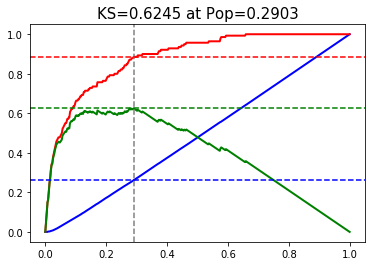

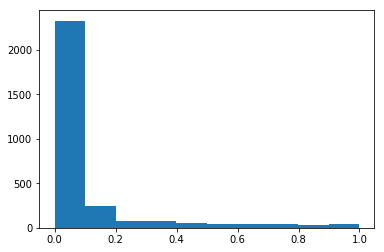

In [270]:
model = lgb_sklearn(train_x, test_x, train_y, test_y)

In [271]:
# 输出结果
predict_data = test_data[model_fea]
res = pd.DataFrame()
res["id"] = test_data["PERSONID"]
res["y_pred"] = model.predict_proba(predict_data)[:,1]
res.to_csv("./data/output/res.txt",index=None,header=None,sep="\t")